In [19]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import nltk
import os
from sklearn import metrics
from gensim.models import KeyedVectors
from sklearn.svm import SVC
import gensim
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# keras
np.random.seed(13)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras import callbacks


In [138]:
#DataFrame that was NOT downsampled

with open('EHR_df_whole_final', 'rb') as f:
    EHR_df2 = pickle.load(f)

In [2]:
 #DataFrame that was downsampled for the non-stroke class.
with open('EHR_df_final', 'rb') as f:
     EHR_df2 = pickle.load(f)

## Setting up Train/Test split

In [12]:
X = EHR_df2.HISTORY_INFO
y = EHR_df2.stroke_label

In [13]:
#transform labels
# define a dict to with key as a label and value as a numeric value
labels_dict = {'stroke':1, 'non-stroke':0}
y = [labels_dict[key] for key in y]

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=10)

## Vectorizing the Corpus with Count Vec, TFIDF, Word2Vec

In [6]:
#Helper Function to load up a pre-trained Word2Vec

class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model


In [7]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    def fit_transform(self, X, y=None):
        return self.transform(X)
    

In [8]:
w2vec = get_word2vec(MySentences(EHR_df2.HISTORY_INFO.values),'w2vmodel')


Found w2vmodel


Now that we have our word2vec model, how do we use it to transform each documents into a feature vector? In order to convert a document of multiple words into a single vector using our trained word2vec, we take the word2vec of all words in the document, then take its mean. We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector. This code was inspired/borrowed from @.

In [15]:
w2v_vectorizer = MeanEmbeddingVectorizer(w2vec)

#Word Embeddings of our corpus
w2v_X_train = w2v_vectorizer.fit_transform(X_train)
w2v_X_test = w2v_vectorizer.transform(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [16]:
count_vectorizer = CountVectorizer(ngram_range=(2,2))
X_train_count = count_vectorizer.fit_transform(X_train)
print('The number of features in X_train with count vec transform is {}'.format(X_train_count.shape[1]))
X_test_count = count_vectorizer.transform(X_test)
print('The number of features in X_test with count vec transform is {}'.format(X_train_count.shape[1]))

The number of features in X_train with count vec transform is 96207
The number of features in X_test with count vec transform is 96207


In [17]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print('The number of features in X_train with tfidf transform is {}'.format(X_train_tfidf.shape[1]))

X_test_tfidf = tfidf_vectorizer.transform(X_test)
print('The number of features in X_test with tfidf transform is {}'.format(X_train_tfidf.shape[1]))



The number of features in X_train with tfidf transform is 96207
The number of features in X_test with tfidf transform is 96207


Since there are 96207 unique words in the whole corpus, we will need to shrink the dimensions down using Truncated SVD.

In [18]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_X_train_count = svd.fit_transform(X_train_count)
truncated_X_test_count = svd.transform(X_test_count)

In [19]:
truncated_X_train_tfidf = svd.fit_transform(X_train_tfidf)
truncated_X_test_tfidf = svd.transform(X_test_tfidf)

Now that the dimensions are reduced from SVD, we can go into Modeling part. 

## Metric 

We will be optimizing our models based on the 'Recall' metric for our classification of stroke vs no stroke. 

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for i in range(2):
            cm[i] = [math.ceil(j*100)/100 for j in cm[i]]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
def Model_Evaluation(X_train,X_test,y_train,y_test,model=None,param_grid={},cv=5):
    '''General helper function for evaluating the passes features in ML Model
    
    Prints out confusion matrix for a 5 CV fold
    
    Input: 
        X_train, X_test (array-like): n_samples x n_features
        y_train, y_test (array-like): n_samples x target
        model : Classifier to use, if None it will use Logistic Regression
        param_grid: Hyper parameters you would like to tune via GridSearch
    '''
    
    #Choosing which model to use :
    if model == 'RandomForest':
        model = RandomForestClassifier(n_jobs=-1,random_state=41,verbose=10)
    elif model == 'XGBoost':
        model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', n_jobs=-1,random_state=41,verbose=10)
    elif model =='SVC':
        model = SVC(verbose=10,random_state=41)
    elif model == None:
        model = LogisticRegression(solver = 'liblinear', n_jobs=-1,random_state=41,verbose=10)
        
    #Setting up cv method:
    cv= StratifiedKFold(n_splits=cv)
    
    grid = GridSearchCV(model,cv=cv,param_grid=param_grid,verbose=10,n_jobs=-1,scoring='recall',return_train_score=True)
    grid.fit(X_train,y_train)
    
    #Printing the GridSearch Results:
    
    print('The results are : {}'.format(grid.cv_results_))
    print('\n')
    
    print('The best parameters for the estimator is {}'.format(grid.best_params_))
    print('\n')
    
    print('The best score from the grid search is {}'.format(grid.best_score_))
    print('\n')
    
    #Making predictions:
    predictions = grid.predict(X_test)
    
    #Returning Classification Report:
    report =  classification_report(y_test, predictions)
    return print(report),grid
    

In [45]:
#helper function that will be used to make confusion matrix plots
def confusion_matrix(cm,classes,normalize=False,title='confusion matrix', cmap=plt.cm.Blues):
    '''This helper function will help print and plot a confusion matrix'''
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arrange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for i in range(2):
            cm[i] = [math.ceil(j*100)/100 for j in cm[i]]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Logistic Regression

In [24]:
#Hyperparameter tunning from Logistic Regression
param_grid = {'penalty' : ['l1','l2'], 'C' : np.logspace(-4, 4, 20)}

### Count Vec

In [25]:
lr_count_report,lr_count_model = Model_Evaluation(truncated_X_train_count,truncated_X_test_count,y_train,y_test,model=None,param_grid=param_grid,cv=5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0304s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[LibLinear]The results are : {'mean_fit_time': array([0.00427403, 0.00514121, 0.00418854, 0.00523372, 0.00434413,
       0.00664783, 0.00476551, 0.00934129, 0.00450096, 0.00897999,
       0.00561376, 0.01234527, 0.01064563, 0.01365862, 0.01216798,
       0.01698594, 0.01821361, 0.02245398, 0.03597822, 0.03031287,
       0.05335941, 0.03634038, 0.0687098 , 0.04645009, 0.07265897,
       0.04787054, 0.0811408 , 0.05260787, 0.08113499, 0.04955716,
       0.08693633, 0.05125694, 0.08093739, 0.04890924, 0.07473254,
       0.05008955, 0.06630864, 0.0497252 , 0.06692762, 0.04626017]), 'std_fit_time': array([0.00011681, 0.00018125, 0.00035879, 0.00025266, 0.00028203,
       0.00060252, 0.00089447, 0.0024701 , 0.00024871, 0.00172325,
       0.00027008, 0.00214178, 0.00392549, 0.00049369, 0.00105224,
       0.0036325 , 0.00280601, 0.00285843, 0.01990008, 0.00295045,
       0.01306284, 0.00455174, 0.00737796, 0.00613355, 0.01038227,
       0.00694089, 0.01705456, 0.01072378, 0.0144245 , 0.0134116

[Parallel(n_jobs=-1)]: Done 164 out of 200 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### TFIDF Vec

In [26]:
lr_tfidf_report, lr_tfidf_model = Model_Evaluation(truncated_X_train_tfidf,truncated_X_test_tfidf,y_train,y_test,model=None,param_grid=param_grid,cv=5)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0188s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of 200 | elapsed:    0.5s remaining:    0.8s


[LibLinear]The results are : {'mean_fit_time': array([0.00346408, 0.00507178, 0.00403013, 0.00498304, 0.00443215,
       0.00621738, 0.00447674, 0.00501313, 0.00427232, 0.00646319,
       0.00475597, 0.00571628, 0.00484982, 0.00534225, 0.00568366,
       0.00660105, 0.00906019, 0.00718141, 0.01347795, 0.00628562,
       0.01497159, 0.00829401, 0.01522779, 0.00866675, 0.01909895,
       0.01066079, 0.0165843 , 0.00947332, 0.02020068, 0.01321568,
       0.01838751, 0.01071787, 0.01941686, 0.0118175 , 0.0174437 ,
       0.01233215, 0.01989775, 0.01128726, 0.01547432, 0.01133718]), 'std_fit_time': array([6.33772528e-04, 2.91837259e-04, 2.48342752e-04, 2.44553671e-04,
       3.30130120e-04, 3.27660054e-04, 2.05037228e-04, 1.62380914e-04,
       1.58919359e-04, 6.56386251e-04, 4.10445738e-05, 7.10820952e-04,
       1.08779359e-04, 1.79802578e-04, 1.39767064e-04, 8.59285636e-04,
       8.64274135e-04, 7.50293639e-04, 1.67124219e-03, 1.42946952e-04,
       1.30081256e-03, 8.07766517e-04, 6.792

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### Word2Vec

In [27]:
w2v_report, w2v_model =Model_Evaluation(w2v_X_train,w2v_X_test,y_train,y_test,model=None,param_grid=param_grid,cv=5)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0399s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[LibLinear]The results are : {'mean_fit_time': array([0.01362977, 0.01962552, 0.01172123, 0.03140993, 0.01663885,
       0.0424437 , 0.01648188, 0.06787658, 0.01535754, 0.07304621,
       0.04081626, 0.10402951, 0.04342175, 0.11418319, 0.05854387,
       0.15036898, 0.1258883 , 0.18009696, 0.39825006, 0.19230437,
       0.9502923 , 0.27188764, 1.75459266, 0.30953207, 2.11667137,
       0.33144116, 2.28123484, 0.33062034, 2.48807259, 0.29466195,
       2.63078203, 0.25854921, 2.48433933, 0.2768404 , 2.42922034,
       0.25096354, 2.21190629, 0.27406015, 1.65033312, 0.25495896]), 'std_fit_time': array([0.00254051, 0.00100505, 0.00147019, 0.01113066, 0.00204479,
       0.00872452, 0.00214494, 0.01564436, 0.00161441, 0.01087265,
       0.00588619, 0.00999662, 0.00399823, 0.00859188, 0.00789364,
       0.00390074, 0.01390274, 0.0103399 , 0.26245797, 0.02008385,
       0.45368824, 0.03433391, 0.37297782, 0.03428076, 0.31110125,
       0.03091823, 0.37575705, 0.04590065, 0.4703256 , 0.0424102

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.8s finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


## Random Forest

In [29]:
# hyperparameters tunning for RandomForest
param_grid = {
    'max_depth': [30,50,100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [20,100,500]
}

### Count Vec

In [30]:
count_rf_report, rf_count_model = Model_Evaluation(truncated_X_train_count,truncated_X_test_count,y_train,y_test,model='RandomForest',param_grid=param_grid,cv=5)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

building tree 1 of 500building tree 2 of 500
building tree 3 of 500building tree 4 of 500
building tree 5 of 500
building tree 6 of 500

building tree 7 of 500

building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500building tree 13 of 500

building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500building tree 19 of 500
building tree 20 of 500building tree 21 of 500


building tree 22 of 500building tree 23 of 500

building tree 24 of 500
building tree 25 of 500building tree 26 of 500

building tree 27 of 500building tree 28 of 500
building tree 29 of 500

building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500building tree 35 of 500building tree 36 of 500


building tree 37 of 500
building tree 38 of 500
building tree 39 of 500building tree 40 of 500

building tree 41 of 500
building tree 42 of 500bu

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 114 of 500
building tree 115 of 500building tree 116 of 500

building tree 117 of 500
building tree 118 of 500building tree 119 of 500
building tree 120 of 500

building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500building tree 126 of 500
building tree 127 of 500building tree 128 of 500
building tree 129 of 500


building tree 130 of 500
building tree 131 of 500
building tree 132 of 500building tree 133 of 500building tree 134 of 500


building tree 135 of 500
building tree 136 of 500building tree 137 of 500

building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500building tree 143 of 500

building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.4s


building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500building tree 233 of 500building tree 234 of 500

building tree 235 of 500

building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500building tree 241 of 500

building tree 242 of 500
building tree 243 of 500
building tree 244 of 500building tree 245 of 500

building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500building tree 253 of 500

building tree 254 of 500
building tree 255 of 500
building tree 256 of 500building tree 257 of 500

building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.6s


building tree 323 of 500
building tree 324 of 500
building tree 325 of 500building tree 326 of 500

building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500building tree 331 of 500
building tree 332 of 500

building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500building tree 338 of 500

building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500building tree 348 of 500

building tree 349 of 500
building tree 350 of 500building tree 351 of 500

building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s



building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500building tree 432 of 500
building tree 433 of 500

building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500building tree 443 of 500building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500


building tree 448 of 500
building tree 449 of 500
building tree 450 of 500building tree 451 of 500

building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   

The results are : {'mean_fit_time': array([0.152352  , 0.39274793, 2.79063182, 0.15896978, 0.9599895 ,
       2.85863781, 0.12985907, 0.93449731, 3.0272625 , 0.13070631,
       1.0386518 , 3.77103662, 0.13612981, 1.07975693, 4.0167048 ,
       0.15578117, 0.98037581, 3.92537465, 0.14387965, 0.96549735,
       3.40393023, 0.15474629, 0.90416083, 3.14074593, 0.1245924 ,
       0.85809484, 3.177317  , 0.13986716, 1.11062002, 3.99256091,
       0.13747716, 1.21608148, 3.9123755 , 0.14475765, 1.0328783 ,
       3.96595459, 0.13277736, 0.94828944, 3.59686904, 0.13014679,
       0.97732134, 3.24553466, 0.13384356, 1.03907013, 3.23295794,
       0.12554846, 1.0273582 , 4.02194681, 0.13544703, 1.18676901,
       4.01661139, 0.13803277, 1.16383114, 3.2000731 ]), 'std_fit_time': array([0.03647099, 0.02445417, 0.12707568, 0.03999809, 0.16675105,
       0.10025413, 0.00618497, 0.07016225, 0.20322939, 0.00436441,
       0.15378327, 0.12439036, 0.00749379, 0.10656816, 0.10929962,
       0.03660945, 0

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       415
           1       0.69      0.67      0.68       324

   micro avg       0.72      0.72      0.72       739
   macro avg       0.72      0.72      0.72       739
weighted avg       0.72      0.72      0.72       739



[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 465 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


### TFIDF Vec

In [31]:
rf_tfidf_report, rf_tfidf_model = Model_Evaluation(truncated_X_train_tfidf,truncated_X_test_tfidf,y_train,y_test,model='RandomForest',param_grid=param_grid,cv=5)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20building tree 4 of 20

building tree 5 of 20building tree 6 of 20
building tree 7 of 20

building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20building tree 14 of 20
building tree 15 of 20building tree 16 of 20


building tree 17 of 20building tree 18 of 20

building tree 19 of 20
building tree 20 of 20
The results are : {'mean_fit_time': array([0.13142643, 0.40355773, 2.923914  , 0.17515287, 0.92545176,
       3.00527511, 0.14425802, 0.87218022, 3.19198594, 0.13940248,
       1.14936943, 3.88854737, 0.14647431, 1.07233548, 4.32268205,
       0.14020162, 1.10127883, 3.9938755 , 0.1367826 , 1.04776478,
       3.56380949, 0.13011789, 1.00839148, 3.2685853 , 0.12870755,
       0.99235005, 3.34875832, 0.13228884, 1.17699795, 3.97452483,
       0.131148  , 1.07974148, 4.31416097, 0.13780642, 1.16189699,
       4.09517255, 0.14428301, 1.121666  , 3

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       415
           1       0.71      0.64      0.67       324

   micro avg       0.73      0.73      0.73       739
   macro avg       0.73      0.72      0.72       739
weighted avg       0.73      0.73      0.73       739



### Word 2 Vec

In [32]:
rf_w2v_report, w2v_report_model = Model_Evaluation(w2v_X_train,w2v_X_test,y_train,y_test,model='RandomForest',param_grid=param_grid,cv=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500building tree 21 of 500

building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500

building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500building tree 36 of 500building tree 37 of 500


building tree 38 of 500
building tree 39 of 500building tree 40 of 500

building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 122 of 500
building tree 123 of 500
building tree 124 of 500building tree 125 of 500building tree 126 of 500


building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500building tree 131 of 500
building tree 132 of 500

building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500building tree 139 of 500

building tree 140 of 500building tree 141 of 500building tree 142 of 500


building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500building tree 148 of 500

building tree 149 of 500building tree 150 of 500building tree 151 of 500


building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.4s



building tree 243 of 500
building tree 244 of 500
building tree 245 of 500building tree 246 of 500building tree 247 of 500

building tree 248 of 500
building tree 249 of 500

building tree 250 of 500building tree 251 of 500

building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500
building tree 257 of 500
building tree 258 of 500building tree 259 of 500

building tree 260 of 500building tree 261 of 500
building tree 262 of 500

building tree 263 of 500
building tree 264 of 500building tree 265 of 500

building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500building tree 271 of 500
building tree 272 of 500

building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500building tree 277 of 500

building tree 278 of 500building tree 279 of 500

building tree 280 of 500
building tree 281 of 500
building tree 282 of 500

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    0.6s


building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500building tree 364 of 500

building tree 365 of 500
building tree 366 of 500building tree 367 of 500

building tree 368 of 500building tree 369 of 500
building tree 370 of 500

building tree 371 of 500
building tree 372 of 500building tree 373 of 500

building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500building tree 381 of 500

building tree 382 of 500building tree 383 of 500

building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500building tree 395 of 500

building tree 396 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    0.8s


building tree 472 of 500building tree 473 of 500

building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500building tree 479 of 500

building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500building tree 488 of 500
building tree 489 of 500

building tree 490 of 500building tree 491 of 500

building tree 492 of 500
building tree 493 of 500
building tree 494 of 500building tree 495 of 500
building tree 496 of 500

building tree 497 of 500
building tree 498 of 500building tree 499 of 500

building tree 500 of 500
The results are : {'mean_fit_time': array([0.13996296, 0.4354775 , 2.7147676 , 0.19481049, 0.87444348,
       3.01405177, 0.15065699, 0.79601612, 3.12879024, 0.128585  ,
       1.02913418, 3.81844726, 0.13411922, 1.08969064, 3.94471045,
       0.15522656, 1.05962644, 3.85809

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       415
           1       0.67      0.66      0.67       324

   micro avg       0.71      0.71      0.71       739
   macro avg       0.71      0.71      0.71       739
weighted avg       0.71      0.71      0.71       739



## XG BOOST

In [37]:
#hyperparameter tuning for XGBOOST
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }

### Count Vec

In [38]:
Model_Evaluation(truncated_X_train_count,truncated_X_test_count,y_train,y_test,model='XGBoost',param_grid=params,cv=5)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.1min
[Parallel(

The results are : {'mean_fit_time': array([3.74131837, 3.72877054, 3.62369957, 5.17323799, 4.99465699,
       4.79522672, 6.69581223, 6.45008383, 5.98582811, 3.93429298,
       3.83025346, 3.73153586, 5.22760978, 5.03713388, 4.84470277,
       6.51183853, 6.16701498, 5.89014664, 3.87919731, 3.79589176,
       3.65420265, 5.11822553, 4.93405991, 4.74789748, 6.39454908,
       6.22781863, 5.92801504, 3.88673439, 3.83490806, 3.71436505,
       5.11757798, 4.93147006, 4.77464981, 6.25608029, 6.04043407,
       5.90778298, 3.79646106, 3.68897829, 3.57686982, 4.94873729,
       4.84747314, 4.69964399, 6.17918859, 5.75338569, 4.85145249]), 'std_fit_time': array([0.11640885, 0.00675776, 0.01679526, 0.03689344, 0.02534766,
       0.02517615, 0.14816822, 0.0421881 , 0.02217988, 0.00848583,
       0.02098917, 0.02186434, 0.02736716, 0.01815573, 0.01180299,
       0.03435792, 0.02747149, 0.01781311, 0.0214129 , 0.00965953,
       0.01238621, 0.01512878, 0.02999721, 0.02388825, 0.04288515,
       0

(None,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        error_score='raise-deprecating',
        estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
        n_jobs=-1, nthread=None, objective='binary:logistic',
        random_state=41, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=1, verbose=10),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring='recall', verbose=10))

### TFIDF Vec

In [39]:
Model_Evaluation(truncated_X_train_tfidf,truncated_X_test_tfidf,y_train,y_test,model='XGBoost',param_grid=param_grid,cv=5)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   40.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   40.4s finished


The results are : {'mean_fit_time': array([3.66762538, 3.70434837, 3.72595539, 3.92774358, 3.99569197,
       4.11174164, 4.13210135, 4.10092278, 3.93099899, 3.91436186,
       3.9005506 , 3.86421313, 3.84395499, 3.89835143, 3.8884573 ,
       3.87543006]), 'std_fit_time': array([0.01210732, 0.02523791, 0.01699924, 0.08586498, 0.04304323,
       0.0145154 , 0.03349551, 0.01180999, 0.01837962, 0.00883699,
       0.01360873, 0.01893532, 0.03057114, 0.02106286, 0.01751896,
       0.01862282]), 'mean_score_time': array([0.02015929, 0.02184296, 0.0251061 , 0.02465038, 0.02435184,
       0.02522178, 0.02506537, 0.02436514, 0.02397404, 0.02253118,
       0.02032504, 0.02183895, 0.02209277, 0.02237844, 0.02172141,
       0.01977677]), 'std_score_time': array([0.00223641, 0.00549709, 0.00348116, 0.00494191, 0.00300848,
       0.00392811, 0.0034433 , 0.00357768, 0.00154548, 0.00190268,
       0.00143805, 0.00347504, 0.00160526, 0.00266557, 0.00126459,
       0.00263807]), 'param_C': masked_array

(None,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        error_score='raise-deprecating',
        estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
        n_jobs=-1, nthread=None, objective='binary:logistic',
        random_state=41, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=1, verbose=10),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring='recall', verbose=10))

### Word2Vec

In [134]:
Model_Evaluation(w2v_X_train,w2v_X_test,y_train,y_test,model='XGBoost',param_grid=param_grid,cv=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7

The results are : {'mean_fit_time': array([ 2.29274001, 11.94155841, 45.5478528 ,  2.32831144, 11.34854617,
       43.47412095,  2.47902794, 10.71606617, 42.27657247,  2.3364316 ,
       10.71655622, 41.7911552 ,  2.38036976, 10.41564021, 41.14767513,
        2.28242917, 10.35343714, 40.96582303,  2.27137599, 10.30584717,
       40.82011662,  2.26391473, 10.28069215, 40.92883005,  2.26319256,
       10.35193343, 43.03932829,  2.29695902, 11.45433936, 41.05960555,
        2.2525815 , 10.04418483, 43.73796663,  2.37339244, 11.15946651,
       45.42433138,  2.35985055, 11.82533545, 43.59638433,  2.78018012,
       10.29785624, 45.83303709,  2.6256824 , 11.80324092, 43.53965664,
        2.35764766, 10.75271444, 45.12528791,  2.53769646, 11.5393064 ,
       44.58326588,  2.40987744, 11.08398857, 34.34089408]), 'std_fit_time': array([0.05762408, 0.1569282 , 0.57730643, 0.0714615 , 0.51847878,
       0.96032104, 0.17158137, 0.20801273, 0.33222365, 0.07309064,
       0.09865283, 0.58697094, 0.

## SVC

In [33]:
param_grid = {'C':[1,10,100,1000],'gamma':[1e-3,1e-4], 'kernel':['linear','rbf']}

### Count Vec

In [34]:
Model_Evaluation(truncated_X_train_count,truncated_X_test_count,y_train,y_test,model='SVC',param_grid=param_grid,cv=5)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   34.3s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   43.6s finished


[LibSVM]The results are : {'mean_fit_time': array([ 0.290625  ,  0.43090925,  0.31424723,  0.44444704,  0.65290437,
        0.43550587,  0.65559611,  0.44151292,  2.89196301,  0.42691989,
        2.93064909,  0.44457321, 23.82811799,  0.49267521, 20.67023697,
        0.51762486]), 'std_fit_time': array([9.30831172e-03, 8.31101515e-03, 1.45171146e-02, 5.17274484e-03,
       3.23213126e-02, 8.46117626e-03, 3.28683331e-02, 3.78861974e-03,
       2.39950407e-01, 1.17949638e-02, 2.42015083e-01, 1.62280176e-02,
       3.90307466e+00, 6.79829946e-03, 6.25338410e+00, 1.62614424e-02]), 'mean_score_time': array([0.04626522, 0.08805294, 0.0449964 , 0.0871428 , 0.04587855,
       0.08841891, 0.04400649, 0.08801055, 0.04628329, 0.07872696,
       0.0420867 , 0.08579035, 0.04918756, 0.08206654, 0.03232684,
       0.09029732]), 'std_score_time': array([0.00334312, 0.0047677 , 0.00350697, 0.00520636, 0.0042457 ,
       0.00439078, 0.00569637, 0.00447325, 0.001616  , 0.00400596,
       0.00141222, 0.00

(None,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        error_score='raise-deprecating',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=41,
   shrinking=True, tol=0.001, verbose=10),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring='recall', verbose=10))

### TFIDF Vec

In [35]:
Model_Evaluation(truncated_X_train_tfidf,truncated_X_test_tfidf,y_train,y_test,model='SVC',param_grid=param_grid,cv=5)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:    7.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.6s finished


[LibSVM]The results are : {'mean_fit_time': array([0.2655467 , 0.44301958, 0.27069025, 0.45396957, 0.26535778,
       0.44281826, 0.25750937, 0.42829223, 0.29703217, 0.46610084,
       0.2826685 , 0.4330369 , 0.62175469, 0.39484773, 0.62230449,
       0.4022974 ]), 'std_fit_time': array([0.00363929, 0.0221065 , 0.01625695, 0.01509662, 0.00831823,
       0.00956622, 0.01886743, 0.00691846, 0.01425214, 0.00409348,
       0.00544404, 0.00767287, 0.0374094 , 0.00528569, 0.03289645,
       0.06493842]), 'mean_score_time': array([0.04444571, 0.09193926, 0.05805879, 0.09418783, 0.04587822,
       0.10212474, 0.03865085, 0.09889097, 0.03826346, 0.08806963,
       0.04257302, 0.0817081 , 0.03860583, 0.07880502, 0.03885217,
       0.07889204]), 'std_score_time': array([0.00318932, 0.00666759, 0.00655945, 0.00639463, 0.00329225,
       0.00703032, 0.00416528, 0.00855991, 0.00224279, 0.00165144,
       0.00295388, 0.00412635, 0.00285906, 0.00163927, 0.00278814,
       0.01571097]), 'param_C': mask

(None,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        error_score='raise-deprecating',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=41,
   shrinking=True, tol=0.001, verbose=10),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring='recall', verbose=10))

### Word2Vec

In [36]:
Model_Evaluation(w2v_X_train,w2v_X_test,y_train,y_test,model='SVC',param_grid=param_grid,cv=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  7.8min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 10.8min finished


[LibSVM]The results are : {'mean_fit_time': array([  1.53723078,   1.45696893,   1.54352207,   1.65003915,
         5.56023574,   0.96440349,   5.27026367,   1.17241831,
        43.90192642,   0.85994873,  43.42205682,   0.87866817,
       399.4973434 ,   1.43504105, 321.03039451,   0.86962347]), 'std_fit_time': array([6.11941578e-02, 1.58614454e-02, 5.16944871e-02, 2.78412306e-02,
       3.20356521e-01, 5.55524412e-02, 3.83919579e-01, 5.80123295e-02,
       3.77598752e+00, 2.31055894e-02, 3.92980729e+00, 3.17659849e-02,
       4.47904034e+01, 4.31726601e-02, 8.05015159e+01, 2.59067141e-02]), 'mean_score_time': array([0.14945707, 0.26409631, 0.13708339, 0.27969842, 0.13214283,
       0.18494554, 0.12612476, 0.24447055, 0.13009815, 0.15373082,
       0.12828188, 0.18161922, 0.11089897, 0.1511096 , 0.09573169,
       0.15976591]), 'std_score_time': array([0.0057888 , 0.01713977, 0.0178478 , 0.02940505, 0.00432518,
       0.00582099, 0.00602569, 0.00818917, 0.00515013, 0.00412382,
       

(None,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        error_score='raise-deprecating',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=41,
   shrinking=True, tol=0.001, verbose=10),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring='recall', verbose=10))

# Setting up Keras

### TFIDF

In [3]:
X = EHR_df2.HISTORY_INFO
y = EHR_df2.stroke_label
labels_dict = {'stroke':1, 'non-stroke':0}
y = [labels_dict[key] for key in y]

In [378]:
tk = Tokenizer(num_words=500)
tk.fit_on_texts(X)

In [379]:
X = tk.texts_to_sequences(X)
X = tk.sequences_to_matrix(X,mode='tfidf')
X= pad_sequences(X, maxlen=500)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=20)

In [400]:
#w2vec

### W2Vec


In [409]:
#pretrained_weights=w2vec.wv.vectors

In [411]:
#pretrained_weights.shape

(12986, 100)

### BOW

In [4]:
#Using the Keras Tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

In [5]:
#Padding the Data
X= tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=2000)

In [420]:
#Setting up the LSTM Model
# embed_dim = 128
# lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('w2v_keras', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(input_dim=12986, output_dim=100, 
                    weights=[pretrained_weights]))
model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1298600   
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 1,379,101
Trainable params: 1,379,101
Non-trainable params: 0
_________________________________________________________________
None


In [421]:
#Fitting model

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks=[ckpt_callback])

Train on 2364 samples, validate on 592 samples
Epoch 1/20
2364/2364 [==============================] - 69s 29ms/step - loss: 0.6520 - acc: 0.6138 - val_loss: 0.6114 - val_acc: 0.6605

Epoch 00001: val_loss improved from inf to 0.61141, saving model to w2v_keras
Epoch 2/20
2364/2364 [==============================] - 63s 27ms/step - loss: 0.5920 - acc: 0.6942 - val_loss: 0.5981 - val_acc: 0.6807

Epoch 00002: val_loss improved from 0.61141 to 0.59810, saving model to w2v_keras
Epoch 3/20
2364/2364 [==============================] - 64s 27ms/step - loss: 0.5705 - acc: 0.7115 - val_loss: 0.5836 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.59810 to 0.58361, saving model to w2v_keras
Epoch 4/20
2364/2364 [==============================] - 63s 26ms/step - loss: 0.5465 - acc: 0.7267 - val_loss: 0.5724 - val_acc: 0.6976

Epoch 00004: val_loss improved from 0.58361 to 0.57236, saving model to w2v_keras
Epoch 5/20
2364/2364 [==============================] - 61s 26ms/step - loss: 0.5

In [423]:
model2 = load_model('w2v_keras')

In [424]:
pred=model2.predict_classes(X_test)

In [425]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       391
           1       0.71      0.70      0.71       348

   micro avg       0.73      0.73      0.73       739
   macro avg       0.72      0.72      0.72       739
weighted avg       0.73      0.73      0.73       739



## BOW MODEL

In [7]:
model = load_model('keras_model')

In [8]:
pred=model.predict_classes(X_test)

In [9]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       391
           1       0.71      0.77      0.74       348

   micro avg       0.75      0.75      0.75       739
   macro avg       0.75      0.75      0.75       739
weighted avg       0.75      0.75      0.75       739



Overall, LSTM performed the best in terms of % recall for class 0 and 1 (Stroke and Non-Stroke). If we just look at the % recall of only class 1 (Stroke). Each epoch took around ~ 3 minutes with LSTM

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt    

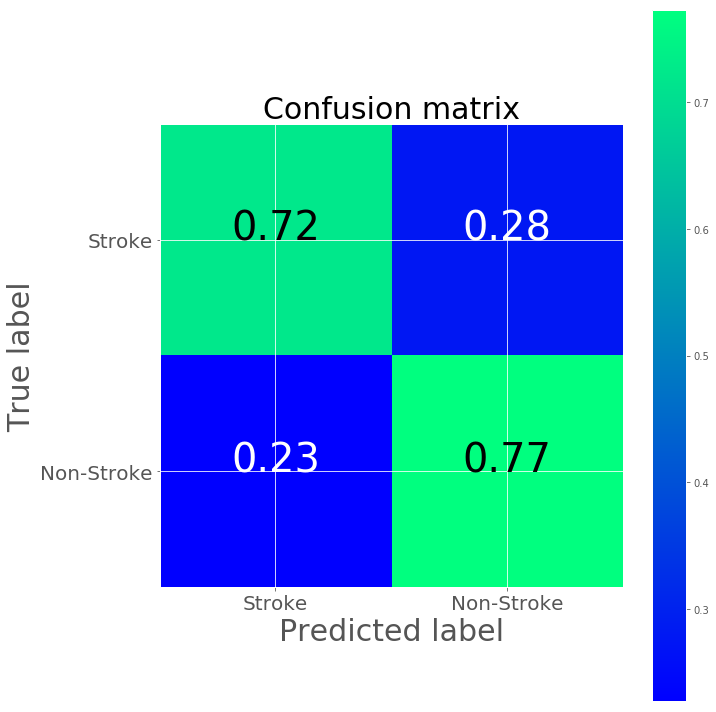

[[283 108]
 [ 79 269]]


In [13]:
cm = confusion_matrix(y_test,pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Stroke','Non-Stroke'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [48]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})


In [36]:
def Performance(Model,Y,X,title):
    # Perforamnce of the model
    fpr, tpr, _ = metrics.roc_curve(Y, Model.predict_proba(X)[:,0])
    AUC  = metrics.auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure(figsize=(12,4))
    plt.plot(fpr, tpr, label='LSTM ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('Roc_curve1.svg', format='svg')

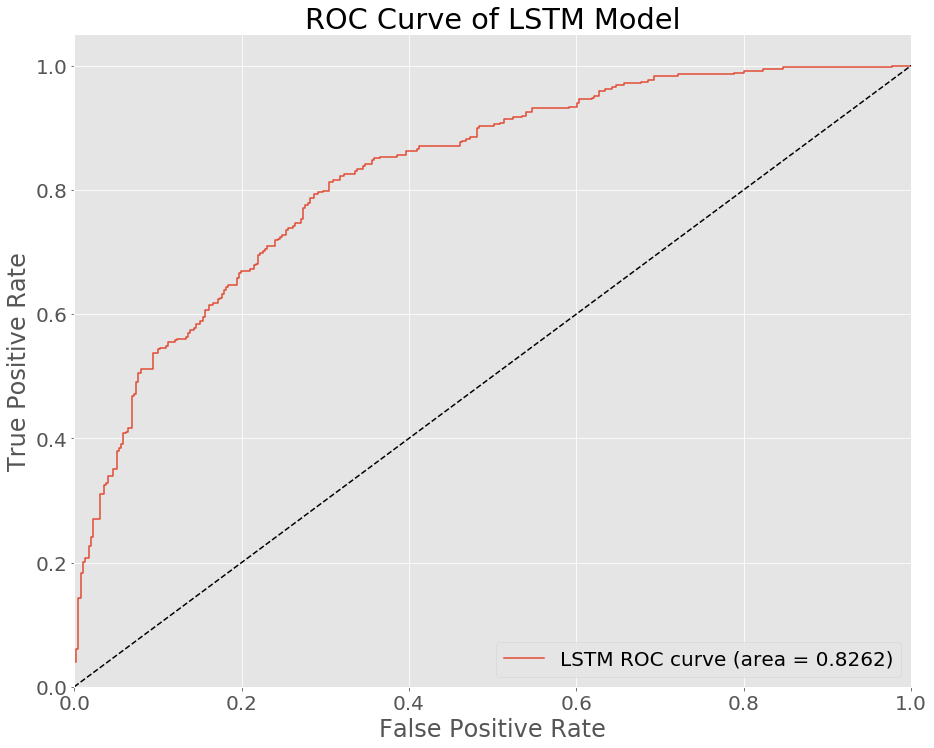

In [50]:
fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,0])
AUC  = metrics.auc(fpr, tpr)
plt.figure(figsize=(15,12))
plt.plot(fpr, tpr, label='LSTM ROC curve (area = %0.4f)' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of LSTM Model')
plt.legend(loc="lower right")
plt.savefig('Roc_curve1.svg', format='svg')
plt.show()
